In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import pprint as pprint

In [4]:
vacstart = "2016-12-29"
vacstop = "2017-01-08"

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
fr = session.query(Measurement).first()
fr.__dict__
    

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x94a11d0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [12]:
fr = session.query(Station).first()
fr.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x94a1e48>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

# Exploratory Climate Analysis

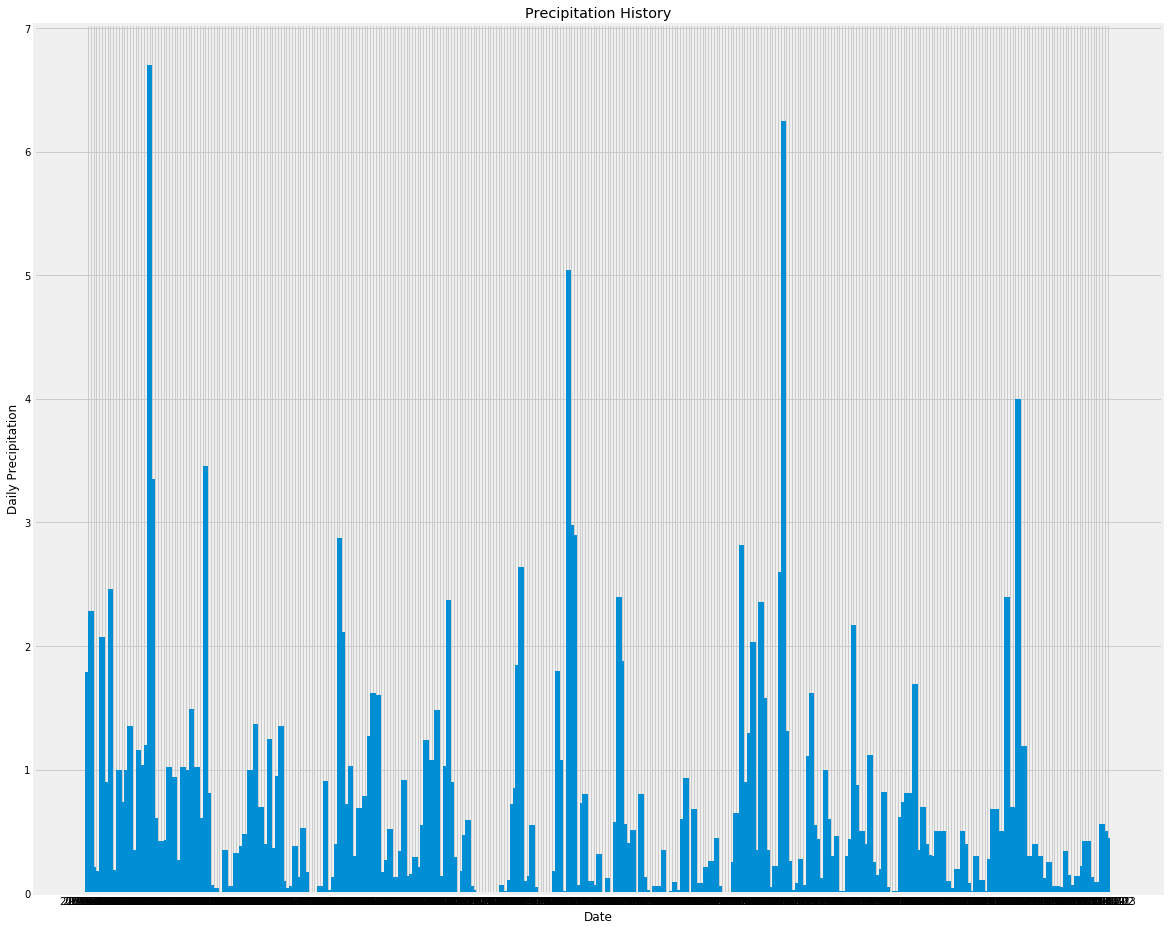

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdate_pd = dt.datetime.strptime(latestdate[0], '%Y-%m-%d').date()
yearago = latestdate_pd - pd.Timedelta('365 days')

# Perform a query to retrieve the data and precipitation scores
prcphistory = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yearago).all()
# prcphistory_df.head(10)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcphistory_df = pd.DataFrame(prcphistory).set_index("date")

# Sort the dataframe by date
prcphistory_df.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(18, 16))
# plt.tick_params(axis="x", which="minor", bottom="off", labelbottom="off")  # figure how to turn X-tick labels OFF
plt.xlabel("Date")
plt.ylabel("Daily Precipitation")
plt.title("Precipitation History")
plt.bar(prcphistory_df.index, prcphistory_df.prcp, width = 2.0)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcphistory_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
numstations = session.query(Measurement.station).distinct().count()
print("Number of stations = ", numstations)

Number of stations =  9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationuse = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stationuse

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Get the busiest station
busieststation = stationuse[0][0]
print(busieststation)

USC00519281


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == busieststation).all()

[(54.0, 85.0, 71.66378066378067)]

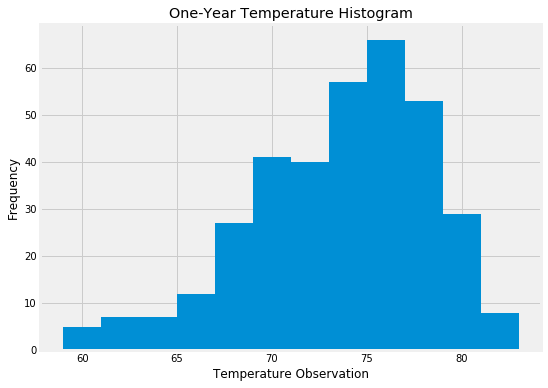

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= yearago, Measurement.station == busieststation).all()
tobs_df = pd.DataFrame(tobs).set_index("date")
tobs_df.sort_index(inplace = True)
tobs_df.head(10)
plt.figure(figsize=(8, 6))
plt.xlabel("Temperature Observation")
plt.ylabel("Frequency")
plt.title("One-Year Temperature Histogram")
plt.hist(tobs_df.tobs, bins=12)
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_prediction = calc_temps(vacstart, vacstop)
print("Hawaii New Year's Holiday ",  vacstart, " to ", vacstop, " temp prediction Low: ", vacation_prediction[0][0], 
      " Average: ", round(vacation_prediction[0][1], 2), " High: ", vacation_prediction[0][2])


Hawaii New Year's Holiday  2016-12-29  to  2017-01-08  temp prediction Low:  60.0  Average:  68.82  High:  77.0


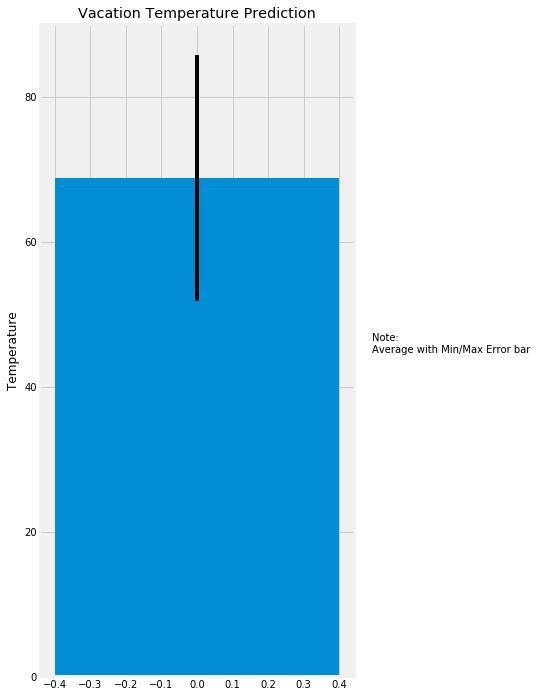

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5, 12))
# plt.tick_params(axis="x", which="minor", bottom="off", labelbottom="off")  # figure how to turn X-tick labels OFF
plt.ylabel("Temperature")
plt.title("Vacation Temperature Prediction")
plt.figtext(1, 0.5, "Note:\nAverage with Min/Max Error bar")
plt.bar(0, vacation_prediction[0][1], yerr=vacation_prediction[0][2]-vacation_prediction[0][0])
plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
refstartdate = dt.datetime.strptime(vacstart, '%Y-%m-%d').date() - pd.Timedelta('365 days')
refstopdate = dt.datetime.strptime(vacstop, '%Y-%m-%d').date() - pd.Timedelta('365 days')
print("\n\n\nRainfall from ", refstartdate, " to ", refstopdate, " at all reporting stations")
print("\nHONOLULU OBSERVATORY and UPPER WAHIAWA reported no results for this time period")

rain = session.query(Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label("Rain")). \
                     outerjoin(Measurement, Measurement.station == Station.station). \
                     filter(Measurement.date >= refstartdate, Measurement.date <= refstopdate). \
                     group_by(Station.name). \
                     order_by(func.sum(Measurement.prcp).desc()).all()
rain
rain_df = pd.DataFrame(rain)
rain_df.sort_values("Rain", ascending = False, inplace = True)
rain_df.head(10)





Rainfall from  2015-12-30  to  2016-01-09  at all reporting stations

HONOLULU OBSERVATORY and UPPER WAHIAWA reported no results for this time period


,name,latitude,longitude,elevation,Rain
0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.07
1,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.56
2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.65
3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
4,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.22
5,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13
6,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


2016-12-29 2017-01-08
12-29 01-08


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
